<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment03/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

### Import

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 601, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 601 (delta 30), reused 19 (delta 19), pack-reused 558 (from 1)
Receiving objects: 100% (601/601), 31.51 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (171/171), done.
PCD  sample_data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
import copy

### Input

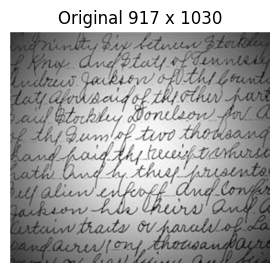

In [3]:
# img_path = '/content/PCD/PCD_Assignment03/images/woman01.jpg'
img_path = '/content/PCD/PCD_Assignment03/images/script.png'
# img_path = '/content/PCD/PCD_Assignment03/images/grid.jpg'
# img_path = '/content/PCD/PCD_Assignment03/images/16x16.jpg'
# img_path = '/content/PCD/PCD_Assignment03/images/8x8.jpg'
# img_path = '/content/PCD/PCD_Assignment03/images/4x4.jpg'
#
img0 = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
# img = img_as_float(img)

img = copy.deepcopy(img0)
# print(img.shape)
# print(img)

plt.figure(figsize=(10,3))
plt.imshow(img, cmap='gray')
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

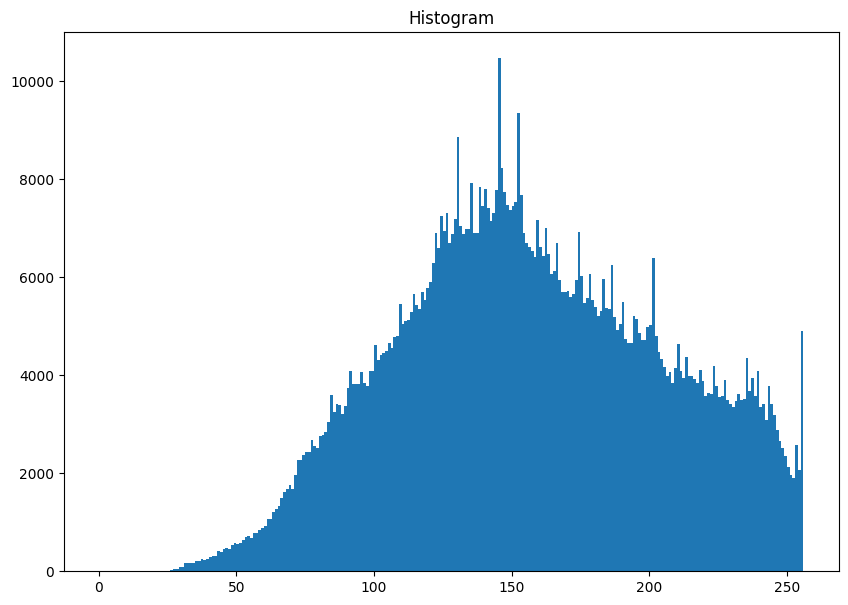

In [35]:
# print(img.shape)
# print(img)

img1d = img.ravel()
sorted = np.sort(img1d)
# print(img1d.shape)
# print(img1d)

val, freq = np.unique(img1d, return_counts=True)
# print(val.shape)
# print(freq.shape)
# print(val)
# print(freq)

bins = np.arange(0, 257)
# print(bins)

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.hist(sorted, bins)
plt.title("Histogram")
# plt.xticks(np.arange(min(bins), max(bins)+1, 1.0))
# plt.yticks(np.arange(min(freq), max(freq)+1, 1.0))
plt.show()

### **Segmentasi**

####  **Pixel based**



##### Basic Global Thresholding

Threshold (T):  159.0


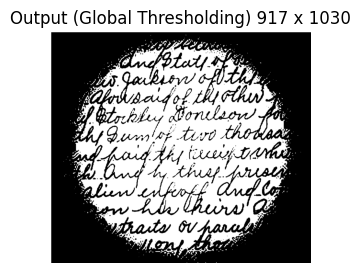

In [5]:
T1 =np.floor(np.mean(img1d))#Nilai Threshold
T2 = T1
T3 = 0
sorted = np.sort(img1d)
output = np.zeros_like(img)

while (T3-T1 != 0):
  first = sorted[sorted <= T2]
  second = sorted[sorted > T2]
  T1 = T2
  # print(first)
  # print(second)
  # print(np.floor(np.mean(first)))
  # print(np.floor(np.mean(second)))

  m1 = np.floor(np.mean(first))
  m2 = np.floor(np.mean(second))
  T3 = (m1+m2)/2
  # print(T1)
  # print(T3)
  # print(T3-T1)
  T2 = T3

T3 = np.floor(T3)
print("Threshold (T): ",T3)

for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i,j] > T3:
      output[i,j] = 255
    else:
      output[i,j] = 0

#Plot
plt.figure(figsize=(10,3))
plt.imshow(output, cmap='gray')
plt.title(f"Output (Global Thresholding) {img.shape[0]} x {img.shape[1]}")
plt.axis("off")
plt.show()

##### Otsu Method

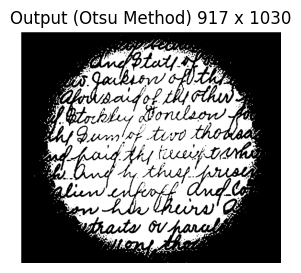

In [46]:
def otsu(input):

  img1d = input.ravel()
  sorted = np.sort(img1d)
  val, freq = np.unique(sorted, return_counts=True)
  # print(val)
  # print(freq)

  # val_freq = np.stack((val,freq), axis=1)
  # print(val_freq)

  var_w = np.zeros(len(val))

  for i in range(1,len(val)):

    weight_b = np.sum(freq[0:i])/np.sum(freq)
    mean_b = np.sum(val[0:i]*freq[0:i])/np.sum(freq[0:i])
    var_b = np.sum(((val[0:i]-mean_b)**2)*freq[0:i])/np.sum(freq[0:i])

    weight_f = np.sum(freq[i:])/np.sum(freq)
    mean_f = np.sum(val[i:]*freq[i:])/np.sum(freq[i:])
    var_f = np.sum(((val[i:]-mean_f)**2)*freq[i:])/np.sum(freq[i:])

    var_w[i] = weight_b*var_b + weight_f*var_f

  # print(var_w.shape)
  # print(var_w)

  mask = (var_w != 0) & ~np.isnan(var_w)
  min_idx = np.nanargmin(np.where(mask, var_w, np.nan))
  min_val = var_w[min_idx]
  # print(min_idx, min_val)
  T = val[min_idx]
  # print("Threshold (T): ",T)

  output = np.zeros_like(input)

  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      if input[i,j] > T:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

output = otsu(img)

#Plot
plt.figure(figsize=(10,3))
plt.imshow(output, cmap='gray')
plt.title(f"Output (Otsu Method) {img.shape[0]} x {img.shape[1]}")
plt.axis("off")
plt.show()

##### Adaptive Thresholding (Membagi citra menjadi beberapa bagian)

Total blocks: 16


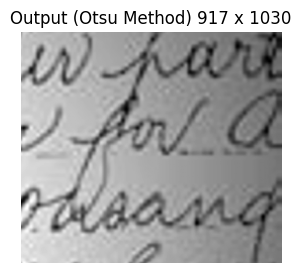

In [47]:
def split_image_blocks(img, rows, cols):
    """Split image into (rows × cols) sub-blocks without cropping."""
    h, w = img.shape[:2]

    # Compute split indices (evenly spaced)
    row_splits = np.linspace(0, h, rows + 1, dtype=int)
    col_splits = np.linspace(0, w, cols + 1, dtype=int)

    # Slice using NumPy indexing
    blocks = [
        img[row_splits[i]:row_splits[i+1], col_splits[j]:col_splits[j+1]]
        for i in range(rows)
        for j in range(cols)
    ]
    return blocks

rows, cols = 4, 4
block = split_image_blocks(img, rows, cols)

print("Total blocks:", len(block))
# print(block[0])
# print("Each block shape:")
# for i, b in enumerate(block):
#     print(f" Block {i}: {b.shape}")

#Plot
plt.figure(figsize=(10,3))
plt.imshow(block[7], cmap='gray')
plt.title(f"Output (Otsu Method) {img.shape[0]} x {img.shape[1]}")
plt.axis("off")
plt.show()

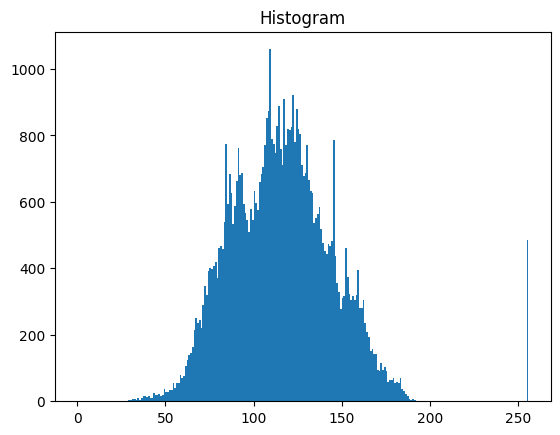

In [43]:
block1d = []
val = []
freq = []
for i in range(len(block)):
  block1d.append(block[i].ravel())

for i in range(len(block1d)):
  nilai, frekuensi = np.unique(block1d[i], return_counts=True)
  val.append(nilai)
  freq.append(frekuensi)

# print(val[0])

# Creating plot
bins = np.arange(0, 257)
# fig = plt.figure(figsize =(10, 7))
plt.hist(block1d[0], bins)
plt.title("Histogram")
# plt.xticks(np.arange(min(bins), max(bins)+1, 1.0))
# plt.yticks(np.arange(min(freq), max(freq)+1, 1.0))
plt.show()

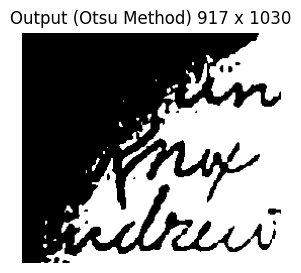

In [48]:
output1 = otsu(block[0])

#Plot
plt.figure(figsize=(10,3))
plt.imshow(output1, cmap='gray')
plt.title(f"Output (Otsu Method) {img.shape[0]} x {img.shape[1]}")
plt.axis("off")
plt.show()

In [ ]:

T1 =np.floor(np.mean(img1d))#Nilai Threshold
T2 = T1
T3 = 0
sorted = np.sort(img1d)
output = np.zeros_like(img)

while (T3-T1 != 0):
  first = sorted[sorted <= T2]
  second = sorted[sorted > T2]
  T1 = T2
  m1 = np.floor(np.mean(first))
  m2 = np.floor(np.mean(second))
  T3 = (m1+m2)/2
  T2 = T3

T3 = np.floor(T3)
print("Threshold (T): ",T3)

for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i,j] > T3:
      output[i,j] = 255
    else:
      output[i,j] = 0

#Plot
plt.figure(figsize=(10,3))
plt.imshow(output, cmap='gray')
plt.title(f"Output (Global Thresholding) {img.shape[0]} x {img.shape[1]}")
plt.axis("off")
plt.show()

##### Probability Thresholding

####  **Edge based**

####  **Region based**

##### Region Growing

##### Watershed / Flood fill

##### Clustering

#### **Feature based / Detection**

##### Sliding Window

### **Morphological Process**